In [ ]:
# Debug: Check the structure of downloaded data
test_data = yf.download(["VTI", "QQQM"], start="2018-01-01", progress=False)
print("Columns:", test_data.columns)
print("Column names level 0:", test_data.columns.get_level_values(0).unique() if isinstance(test_data.columns, pd.MultiIndex) else test_data.columns)
print("Data shape:", test_data.shape)
print(test_data.head())

In [2]:
%pip install yfinance

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 0.0/3.0 MB ? eta -:--:--
     ------------- -------------------------- 1.0/3.0 MB 7.7 MB/s eta 0:00:01
     ---------------------------------------- 3.0/3.0 MB 10.1 MB/s  0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   ---------------------------------------- 1.6/1.6 MB 11.9 MB/s  0:00:00
  Created wheel for multitasking: filename=multitasking-0.0.12-py3-none-any.whl size=15703 sha256=2c4d6b8e6572c91d158b8f0f18fbcafa387f25b74c4e4c26de0bb94821351588
  Stored in directory: c:\users\wongb

  DEPRECATION: Building 'multitasking' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'multitasking'. Discussion can be found at https://github.com/pypa/pip/issues/6334

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
my_tickers = ["VTI", "QQQM", "VUG", "SPMO", "QUAL", "USMV", 'AVUV', 'SPGP', 'VTV', 'MTUM', 'SCHD', 'VXUS', 'VDC', 'AVDV', 'VT', 'QQQ', 'XLV', 'VYM', 'EFA', 'VONG', 'IQLT', 'RPV', 'IWD', 'SPLV', 'VSS', 'XSMO', 'SLYV', 'DFSV', 'RSP', 'DYNF', 'IMTM']

In [67]:
import yfinance as yf
import pandas as pd
import numpy as np

def analyze_recovery_time(
    tickers,
    start_date="1990-01-01",
    end_date=None,
    sort_by="Annualized Drawdown Area (%-days/yr)",
    ascending=False,
    add_rank=True,
    use_adjusted=True,
):
    # 1. Fetch price data (auto-adjusted so we only work with adjusted values)
    raw_data = yf.download(
        tickers,
        start=start_date,
        end=end_date,
        progress=False,
        auto_adjust=True,
    )

    # When auto_adjust=True, yfinance always uses "Close" for successful tickers
    # (failed tickers appear in "Adj Close" but are all NaN)
    price_field = "Close"

    if len(tickers) > 1:
        data = raw_data[price_field]
    else:
        data = pd.DataFrame(raw_data[price_field])
    
    results = {}

    for ticker in tickers:
        if ticker not in data.columns:
            continue
        series = data[ticker].dropna()
        
        if len(series) == 0:
            continue
        
        # 2. Running Maximum and Drawdown
        running_max = series.cummax()
        drawdown = (series / running_max) - 1
        is_underwater = drawdown < 0

        # 3. Underwater duration stats (keep avg and p95 only)
        underwater_groups = (is_underwater != is_underwater.shift()).cumsum()
        underwater_only = underwater_groups[is_underwater]
        if not underwater_only.empty:
            durations = underwater_only.value_counts()
            avg_recovery_days = durations.mean()
            p95_recovery_days = float(durations.quantile(0.95))
        else:
            avg_recovery_days, p95_recovery_days = 0, 0
        
        total_days = len(series)

        # 4. Areas: drawdown area and ascent area; then ratio
        drawdown_area = float((-drawdown[drawdown < 0]).sum() * 100)
        annualized_drawdown_area = round(drawdown_area / (total_days / 252), 2) if total_days else 0

        daily_returns = series.pct_change()
        is_above_max = drawdown >= 0
        ascent_returns = daily_returns[is_above_max & (daily_returns > 0)]
        ascent_area = float(ascent_returns.sum() * 100) if len(ascent_returns) > 0 else 0
        annualized_ascent_area = round(ascent_area / (total_days / 252), 2) if total_days else 0

        ascent_drawdown_ratio = (
            round(annualized_ascent_area / annualized_drawdown_area, 3)
            if annualized_drawdown_area > 0 else np.nan
        )

        # 5. Risk metrics retained
        dd_neg = np.minimum(drawdown, 0)
        ulcer_index = float(np.sqrt((dd_neg ** 2).mean()) * 100) if len(dd_neg) else 0

        # Returns for Sortino and ascent slope
        returns = np.log(series / series.shift(1)).dropna()
        downside_returns = returns[returns < 0]
        downside_volatility = downside_returns.std() * np.sqrt(252) if len(downside_returns) > 0 else 0

        years = total_days / 252 if total_days else 0
        cagr = (series.iloc[-1] / series.iloc[0]) ** (1 / years) - 1 if years > 0 else np.nan

        risk_free_rate = 0.048  # 30-year proxy
        sortino_ratio = (cagr - risk_free_rate) / downside_volatility if downside_volatility > 0 else np.nan

        # Average slope of ascent streaks
        is_up = returns > 0
        up_groups = (is_up != is_up.shift()).cumsum()
        if is_up.any():
            slope_per_streak = []
            for streak_id in up_groups[is_up].unique():
                streak_mask = (up_groups == streak_id) & is_up
                streak_returns = returns[streak_mask]
                if len(streak_returns) > 0:
                    slope = (streak_returns.mean() * 100)
                    slope_per_streak.append(slope)
            avg_ascent_slope = round(np.mean(slope_per_streak), 3) if slope_per_streak else 0
        else:
            avg_ascent_slope = 0

        martin_ratio = cagr / (ulcer_index / 100) if ulcer_index not in (0, np.nan) else np.nan

        # Derived metric using avg recovery days
        return_over_recovery_time = (
            round(cagr * 100 / avg_recovery_days, 3)
            if avg_recovery_days not in (0, np.nan) else np.nan
        )
            
        results[ticker] = {
            # Kept core performance and risk
            "CAGR (%)": round(cagr * 100, 2) if not pd.isna(cagr) else np.nan,
            "Avg Recovery (Trading Days)": round(avg_recovery_days, 1),
            "P95 Recovery (Trading Days)": round(p95_recovery_days, 1),
            "Ascent/Drawdown Area Ratio": ascent_drawdown_ratio,
            "Sortino Ratio": round(sortino_ratio, 3) if not pd.isna(sortino_ratio) else np.nan,
            "Return / Recovery Time": return_over_recovery_time,
            "Avg Ascent Slope (% per day)": avg_ascent_slope,
            "Ulcer Index (%)": round(ulcer_index, 2),
            "Martin Ratio": round(martin_ratio, 3) if not pd.isna(martin_ratio) else np.nan,
            "Current Status": "Underwater" if drawdown.iloc[-1] < 0 else "At High"
        }

    df = pd.DataFrame(results).T

    # 6. Sort and rank by composite criteria (unchanged; columns must exist)
    sort_cols = ["Martin Ratio", "CAGR (%)", "Return / Recovery Time", "Avg Recovery (Trading Days)"]
    sort_ascending = [False, False, True]  # Higher Martin/CAGR better; lower recovery days better

    valid_sorts = [(col, asc) for col, asc in zip(sort_cols, sort_ascending) if col in df.columns]
    
    if valid_sorts:
        cols_to_sort = [col for col, _ in valid_sorts]
        ascending_list = [asc for _, asc in valid_sorts]
        df = df.sort_values(by=cols_to_sort, ascending=ascending_list)
        if add_rank:
            df.insert(0, "Rank", df[cols_to_sort[0]].rank(ascending=ascending_list[0], method="dense").astype(int))

    return df

# Full modern time scale
recovery_stats = analyze_recovery_time(my_tickers, start_date="1990-01-01", end_date=None)
from IPython.display import display
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
display(recovery_stats.T)


,SPMO,USMV,SCHD,SPGP,VONG,QUAL,SPLV,VDC,MTUM,AVDV,QQQM,AVUV,VUG,IQLT,XLV,VT,VTI,VSS,VYM,VTV,VXUS,IWD,RPV,EFA,QQQ
Rank,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
CAGR (%),18.05,11.87,12.34,14.37,17.21,13.45,10.05,9.23,14.92,14.3,16.31,14.23,12.26,7.95,8.58,8.51,9.59,9.29,8.98,9.25,6.1,7.76,8.87,6.23,10.49
Avg Recovery (Trading Days),15.1,12.5,14.8,13.5,12.3,13.1,16.6,16.8,14.6,17.8,17.7,31.7,17.0,25.3,27.2,20.3,18.0,32.0,17.6,17.3,34.3,20.8,29.5,33.6,31.6
P95 Recovery (Trading Days),59.7,42.9,57.8,54.5,55.6,52.8,58.5,61.6,67.7,44.9,39.0,199.1,68.8,82.4,89.1,40.0,55.0,52.0,52.6,45.0,85.8,64.0,102.2,77.0,57.4
Ascent/Drawdown Area Ratio,0.02,0.023,0.02,0.019,0.019,0.017,0.016,0.015,0.013,0.011,0.01,0.009,0.009,0.007,0.007,0.007,0.007,0.005,0.007,0.007,0.004,0.005,0.004,0.003,0.002
Sortino Ratio,0.741,0.614,0.602,0.576,0.791,0.611,0.419,0.403,0.629,0.576,0.709,0.424,0.452,0.22,0.28,0.211,0.306,0.302,0.273,0.281,0.09,0.189,0.194,0.085,0.271
Return / Recovery Time,1.194,0.947,0.833,1.066,1.401,1.03,0.604,0.551,1.019,0.803,0.92,0.448,0.723,0.315,0.315,0.42,0.533,0.29,0.512,0.535,0.178,0.373,0.301,0.185,0.332
Avg Ascent Slope (% per day),0.959,0.59,0.684,0.844,0.85,0.758,0.631,0.635,0.864,0.843,1.062,1.284,0.869,0.813,0.805,0.852,0.82,0.795,0.766,0.791,0.786,0.808,1.022,0.897,1.179
Ulcer Index (%),7.16,4.83,5.16,6.93,8.48,7.18,5.63,6.11,10.51,10.49,13.26,11.87,12.15,8.83,9.96,11.15,12.74,12.62,12.72,13.75,10.81,14.11,17.4,17.03,43.9
Martin Ratio,2.519,2.457,2.393,2.074,2.03,1.874,1.786,1.511,1.42,1.363,1.23,1.198,1.009,0.901,0.861,0.764,0.753,0.736,0.706,0.673,0.564,0.55,0.51,0.366,0.239


In [54]:
# DotCom Bubble Crash
recovery_stats = analyze_recovery_time(my_tickers, start_date="2000-02-10", end_date="2005-01-15")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
display(recovery_stats.T)

$SPLV: possibly delisted; no price data found  (1d 2000-02-10 -> 2005-01-15) (Yahoo error = "Data doesn't exist for startDate = 950158800, endDate = 1105765200")
$VXUS: possibly delisted; no price data found  (1d 2000-02-10 -> 2005-01-15) (Yahoo error = "Data doesn't exist for startDate = 950158800, endDate = 1105765200")
$AVDV: possibly delisted; no price data found  (1d 2000-02-10 -> 2005-01-15) (Yahoo error = "Data doesn't exist for startDate = 950158800, endDate = 1105765200")
$QQQM: possibly delisted; no price data found  (1d 2000-02-10 -> 2005-01-15) (Yahoo error = "Data doesn't exist for startDate = 950158800, endDate = 1105765200")
$VT: possibly delisted; no price data found  (1d 2000-02-10 -> 2005-01-15) (Yahoo error = "Data doesn't exist for startDate = 950158800, endDate = 1105765200")
$SPMO: possibly delisted; no price data found  (1d 2000-02-10 -> 2005-01-15) (Yahoo error = "Data doesn't exist for startDate = 950158800, endDate = 1105765200")
$AVUV: possibly delisted; no p

,VTV,VDC,EFA,VUG,IWD,VTI,XLV,QQQ
Rank,1,2,3,4,5,6,7,8
CAGR (%),11.75,10.59,7.62,2.49,5.48,2.47,0.03,-17.88
Max Drawdown (%),-7.29,-8.16,-31.3,-11.08,-34.08,-34.66,-29.8,-82.96
Above Water Days (%),11.52,12.76,6.35,7.82,5.58,3.44,1.21,0.89
Underwater Days (%),88.48,87.24,93.65,92.18,94.42,96.56,98.79,99.11
Max Recovery (Trading Days),126,127,532,199,652,635,808,1207
Avg Recovery (Trading Days),12.6,16.3,30.6,28.0,33.3,54.3,136.0,204.7
P95 Recovery (Trading Days),40.4,71.2,100.8,133.2,89.4,284.8,578.4,907.5
Annualized Drawdown Area (%-days/yr),530.72,623.08,2442.66,944.31,2203.92,2863.56,2231.99,15568.75
Annualized Ascent Area (%-days/yr),18.08,14.78,11.62,9.58,10.13,4.96,2.75,4.93


In [55]:
# 2005-2007 International Bull Run
recovery_stats = analyze_recovery_time(my_tickers, start_date="2005-01-16", end_date="2007-09-08")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
display(recovery_stats.T)

$SPGP: possibly delisted; no price data found  (1d 2005-01-16 -> 2007-09-08) (Yahoo error = "Data doesn't exist for startDate = 1105851600, endDate = 1189224000")
$VT: possibly delisted; no price data found  (1d 2005-01-16 -> 2007-09-08) (Yahoo error = "Data doesn't exist for startDate = 1105851600, endDate = 1189224000")
$QQQM: possibly delisted; no price data found  (1d 2005-01-16 -> 2007-09-08) (Yahoo error = "Data doesn't exist for startDate = 1105851600, endDate = 1189224000")
$VXUS: possibly delisted; no price data found  (1d 2005-01-16 -> 2007-09-08) (Yahoo error = "Data doesn't exist for startDate = 1105851600, endDate = 1189224000")
$SPMO: possibly delisted; no price data found  (1d 2005-01-16 -> 2007-09-08) (Yahoo error = "Data doesn't exist for startDate = 1105851600, endDate = 1189224000")
$AVUV: possibly delisted; no price data found  (1d 2005-01-16 -> 2007-09-08) (Yahoo error = "Data doesn't exist for startDate = 1105851600, endDate = 1189224000")
$AVDV: possibly delisted

,VDC,VTV,IWD,EFA,VTI,RPV,VUG,VYM,XLV,QQQ
Rank,1,2,3,4,5,6,7,8,9,10
CAGR (%),8.53,12.08,11.77,17.85,10.54,10.56,8.92,6.87,6.84,9.01
Max Drawdown (%),-5.27,-10.46,-10.55,-15.76,-9.47,-12.22,-9.4,-8.32,-9.85,-17.27
Above Water Days (%),14.44,18.95,18.95,16.84,16.39,21.58,12.63,20.79,10.83,10.38
Underwater Days (%),85.56,81.05,81.05,83.16,83.61,78.42,87.37,79.21,89.17,89.62
Max Recovery (Trading Days),83,71,72,118,97,86,104,39,110,211
Avg Recovery (Trading Days),10.7,9.1,8.7,10.1,12.1,9.3,13.8,8.0,13.8,28.4
P95 Recovery (Trading Days),44.8,39.6,44.6,38.6,63.0,36.9,69.3,36.2,69.6,122.0
Annualized Drawdown Area (%-days/yr),328.83,434.34,441.23,712.39,496.08,533.83,562.05,423.34,635.94,1026.56
Annualized Ascent Area (%-days/yr),15.91,21.91,21.42,30.42,18.68,24.74,14.93,24.02,16.55,13.32


In [56]:
# GFC
recovery_stats = analyze_recovery_time(my_tickers, start_date="2007-09-09", end_date="2013-02-25")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
display(recovery_stats.T)

$AVDV: possibly delisted; no price data found  (1d 2007-09-09 -> 2013-02-25) (Yahoo error = "Data doesn't exist for startDate = 1189310400, endDate = 1361768400")
$QUAL: possibly delisted; no price data found  (1d 2007-09-09 -> 2013-02-25) (Yahoo error = "Data doesn't exist for startDate = 1189310400, endDate = 1361768400")
$SPMO: possibly delisted; no price data found  (1d 2007-09-09 -> 2013-02-25) (Yahoo error = "Data doesn't exist for startDate = 1189310400, endDate = 1361768400")
$AVUV: possibly delisted; no price data found  (1d 2007-09-09 -> 2013-02-25) (Yahoo error = "Data doesn't exist for startDate = 1189310400, endDate = 1361768400")
$QQQM: possibly delisted; no price data found  (1d 2007-09-09 -> 2013-02-25) (Yahoo error = "Data doesn't exist for startDate = 1189310400, endDate = 1361768400")
$IQLT: possibly delisted; no price data found  (1d 2007-09-09 -> 2013-02-25) (Yahoo error = "Data doesn't exist for startDate = 1189310400, endDate = 1361768400")
$MTUM: possibly delist

,USMV,SCHD,SPLV,VONG,SPGP,VSS,VDC,XLV,QQQ,VUG,RPV,VTI,VYM,VT,VXUS,IWD,VTV,EFA
Rank,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
CAGR (%),18.63,19.04,14.03,15.22,13.62,19.39,9.69,6.43,7.08,5.03,4.61,3.67,3.58,2.7,1.47,1.7,1.59,-1.75
Max Drawdown (%),-5.94,-6.84,-12.48,-18.0,-17.18,-29.09,-34.24,-39.17,-53.4,-50.68,-73.99,-55.45,-56.98,-50.26,-26.98,-59.85,-59.2,-61.04
Above Water Days (%),23.21,21.13,16.34,15.11,13.21,10.02,10.55,6.19,6.62,4.8,3.49,3.06,3.93,2.98,3.27,1.46,1.46,1.46
Underwater Days (%),76.79,78.87,83.66,84.89,86.79,89.98,89.45,93.81,93.38,95.2,96.51,96.94,96.07,97.02,96.73,98.54,98.54,98.54
Max Recovery (Trading Days),63,63,78,145,131,456,569,849,781,823,891,1114,1114,631,456,1332,1337,1336
Avg Recovery (Trading Days),6.8,7.8,11.8,12.6,18.4,19.1,19.2,29.3,33.8,40.9,53.0,55.5,44.0,56.9,55.9,123.1,150.4,169.2
P95 Recovery (Trading Days),26.7,34.4,45.5,76.0,89.2,51.8,62.9,53.0,107.2,117.0,185.6,91.5,58.9,430.6,282.0,669.5,805.0,871.5
Annualized Drawdown Area (%-days/yr),282.44,341.75,457.11,907.96,1003.32,2355.92,1509.44,2819.29,3638.52,3465.44,5176.88,4216.48,4492.77,3365.79,3118.92,5777.01,5706.25,7158.92
Annualized Ascent Area (%-days/yr),30.72,25.61,21.44,20.91,18.44,28.82,13.39,9.71,11.1,7.01,6.92,5.32,5.67,4.74,6.54,2.6,2.37,3.2


In [57]:
# 2013-2015 Recovery Bull Run
recovery_stats = analyze_recovery_time(my_tickers, start_date="2013-02-26", end_date="2015-05-22")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
display(recovery_stats.T)

$QQQM: possibly delisted; no price data found  (1d 2013-02-26 -> 2015-05-22) (Yahoo error = "Data doesn't exist for startDate = 1361854800, endDate = 1432267200")
$AVDV: possibly delisted; no price data found  (1d 2013-02-26 -> 2015-05-22) (Yahoo error = "Data doesn't exist for startDate = 1361854800, endDate = 1432267200")
$SPMO: possibly delisted; no price data found  (1d 2013-02-26 -> 2015-05-22) (Yahoo error = "Data doesn't exist for startDate = 1361854800, endDate = 1432267200")
$AVUV: possibly delisted; no price data found  (1d 2013-02-26 -> 2015-05-22) (Yahoo error = "Data doesn't exist for startDate = 1361854800, endDate = 1432267200")

4 Failed downloads:
['QQQM', 'AVDV', 'SPMO', 'AVUV']: possibly delisted; no price data found  (1d 2013-02-26 -> 2015-05-22) (Yahoo error = "Data doesn't exist for startDate = 1361854800, endDate = 1432267200")


,IQLT,XLV,QQQ,VONG,SPGP,VTI,VUG,USMV,RPV,QUAL,VTV,VYM,IWD,SCHD,VDC,MTUM,SPLV,VT,EFA,VXUS,VSS
Rank,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
CAGR (%),32.54,30.29,27.1,21.16,20.8,19.51,20.94,16.86,23.02,17.09,18.33,17.27,17.56,16.84,16.48,19.51,14.73,13.91,11.11,9.09,9.35
Max Drawdown (%),-3.68,-7.75,-8.25,-7.36,-8.58,-7.57,-7.57,-6.64,-8.84,-6.63,-7.62,-6.7,-7.85,-6.68,-7.54,-8.9,-7.13,-9.4,-14.69,-13.85,-16.25
Above Water Days (%),40.0,22.7,24.11,24.47,22.34,21.45,23.76,21.81,19.5,21.51,22.34,23.05,21.81,20.92,16.49,19.51,18.26,14.89,9.4,8.33,9.22
Underwater Days (%),60.0,77.3,75.89,75.53,77.66,78.55,76.24,78.19,80.5,78.49,77.66,76.95,78.19,79.08,83.51,80.49,81.74,85.11,90.6,91.67,90.78
Max Recovery (Trading Days),26,62,56,56,36,36,55,86,51,37,43,43,85,57,61,74,83,158,222,222,222
Avg Recovery (Trading Days),5.1,7.5,7.6,7.9,7.6,8.1,8.4,8.0,9.9,8.9,7.8,7.2,8.3,9.3,10.5,10.1,10.2,13.0,23.2,24.6,23.3
P95 Recovery (Trading Days),17.4,30.0,36.2,32.0,31.7,30.9,33.0,31.9,38.5,28.0,32.0,31.1,32.4,34.6,51.0,37.6,44.2,38.0,74.4,89.0,83.6
Annualized Drawdown Area (%-days/yr),207.58,352.58,347.81,307.59,294.06,301.47,335.24,268.26,378.09,285.7,308.19,303.08,316.56,316.77,348.34,444.25,361.84,448.61,917.48,934.84,1170.75
Annualized Ascent Area (%-days/yr),53.23,37.38,34.27,27.43,27.83,24.81,26.95,23.4,29.88,22.08,24.65,23.6,24.62,21.94,22.98,26.39,22.88,18.53,14.19,12.03,13.51


In [58]:
# 2015-2016 Stock Market Selloff
recovery_stats = analyze_recovery_time(my_tickers, start_date="2015-05-23", end_date="2016-08-22")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
display(recovery_stats.T)

$QQQM: possibly delisted; no price data found  (1d 2015-05-23 -> 2016-08-22) (Yahoo error = "Data doesn't exist for startDate = 1432353600, endDate = 1471838400")
$AVDV: possibly delisted; no price data found  (1d 2015-05-23 -> 2016-08-22) (Yahoo error = "Data doesn't exist for startDate = 1432353600, endDate = 1471838400")
$AVUV: possibly delisted; no price data found  (1d 2015-05-23 -> 2016-08-22) (Yahoo error = "Data doesn't exist for startDate = 1432353600, endDate = 1471838400")

3 Failed downloads:
['QQQM', 'AVDV', 'AVUV']: possibly delisted; no price data found  (1d 2015-05-23 -> 2016-08-22) (Yahoo error = "Data doesn't exist for startDate = 1432353600, endDate = 1471838400")


,SPLV,USMV,VDC,SPMO,SCHD,MTUM,VYM,QUAL,QQQ,VONG,VTV,VTI,VUG,IWD,SPGP,XLV,VT,RPV,VSS,IQLT,VXUS,EFA
Rank,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
CAGR (%),12.85,11.65,11.97,10.26,8.99,8.37,7.42,6.12,7.03,4.99,5.1,4.19,4.13,3.75,1.88,1.68,-0.43,-0.51,-2.03,-3.89,-5.27,-6.32
Max Drawdown (%),-11.3,-9.5,-10.01,-11.03,-12.99,-12.95,-12.51,-11.49,-16.1,-13.8,-12.99,-15.13,-15.6,-16.05,-19.37,-17.09,-19.16,-22.39,-20.98,-19.62,-23.35,-21.9
Above Water Days (%),13.69,14.33,12.42,16.59,11.46,9.87,9.55,7.96,6.37,6.69,7.64,5.73,6.05,6.37,3.18,3.82,0.64,1.59,1.27,1.59,0.64,0.96
Underwater Days (%),86.31,85.67,87.58,83.41,88.54,90.13,90.45,92.04,93.63,93.31,92.36,94.27,93.95,93.63,96.82,96.18,99.36,98.41,98.73,98.41,99.36,99.04
Max Recovery (Trading Days),49,92,54,162,110,91,198,109,163,244,206,241,246,240,263,275,312,293,307,289,312,293
Avg Recovery (Trading Days),10.0,12.2,10.2,90.5,16.4,14.9,18.9,20.6,29.4,22.5,19.3,21.1,24.6,22.6,50.7,43.1,312.0,77.2,155.0,154.5,312.0,155.5
P95 Recovery (Trading Days),41.8,41.4,37.7,154.8,91.6,90.1,78.3,83.6,121.1,107.8,78.6,97.3,120.0,105.0,201.0,196.4,312.0,250.2,291.8,275.6,312.0,279.2
Annualized Drawdown Area (%-days/yr),492.56,468.73,513.86,586.03,684.86,684.92,706.31,747.02,1218.85,903.44,931.27,1033.02,1057.49,1213.89,1426.59,1764.85,1849.3,1920.33,2330.53,2283.85,2859.06,2602.34
Annualized Ascent Area (%-days/yr),20.57,17.05,21.76,12.72,14.11,15.41,12.84,10.78,9.75,8.22,9.48,7.67,6.77,8.69,5.59,5.31,0.7,2.5,1.14,2.13,0.61,1.0


In [59]:
# 2016-2018 Bull Run
recovery_stats = analyze_recovery_time(my_tickers, start_date="2016-08-23", end_date="2018-07-19")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
display(recovery_stats.T)

$AVUV: possibly delisted; no price data found  (1d 2016-08-23 -> 2018-07-19) (Yahoo error = "Data doesn't exist for startDate = 1471924800, endDate = 1531972800")
$QQQM: possibly delisted; no price data found  (1d 2016-08-23 -> 2018-07-19) (Yahoo error = "Data doesn't exist for startDate = 1471924800, endDate = 1531972800")
$AVDV: possibly delisted; no price data found  (1d 2016-08-23 -> 2018-07-19) (Yahoo error = "Data doesn't exist for startDate = 1471924800, endDate = 1531972800")

3 Failed downloads:
['AVUV', 'QQQM', 'AVDV']: possibly delisted; no price data found  (1d 2016-08-23 -> 2018-07-19) (Yahoo error = "Data doesn't exist for startDate = 1471924800, endDate = 1531972800")


,SPGP,QQQ,SPMO,MTUM,VONG,VUG,VTI,QUAL,VT,USMV,VTV,RPV,SPLV,VYM,VSS,IWD,SCHD,EFA,VXUS,IQLT,XLV,VDC
Rank,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
CAGR (%),26.31,26.31,22.66,24.05,22.02,19.88,16.78,15.13,13.9,11.34,13.83,14.82,9.65,11.74,11.82,10.81,12.67,10.82,11.01,9.84,10.49,1.09
Max Drawdown (%),-9.65,-10.52,-9.5,-10.23,-9.8,-9.79,-9.84,-9.92,-9.88,-9.17,-10.78,-11.01,-8.91,-10.97,-9.86,-10.55,-12.37,-10.08,-11.63,-8.9,-12.79,-15.26
Above Water Days (%),22.96,23.17,28.6,22.13,25.26,21.29,19.42,17.95,20.67,16.08,17.95,12.32,12.73,16.7,16.28,15.24,19.21,17.12,17.12,13.57,9.39,7.1
Underwater Days (%),77.04,76.83,71.4,77.87,74.74,78.71,80.58,82.05,79.33,83.92,82.05,87.68,87.27,83.3,83.72,84.76,80.79,82.88,82.88,86.43,90.61,92.9
Max Recovery (Trading Days),93,57,69,93,88,89,119,119,119,119,119,119,119,119,119,119,119,119,119,129,123,126
Avg Recovery (Trading Days),6.5,7.2,11.4,7.8,7.6,7.2,9.0,11.9,8.3,12.6,10.9,19.1,18.2,12.5,10.6,13.1,12.1,10.2,9.9,15.3,20.7,21.2
P95 Recovery (Trading Days),24.8,27.5,44.4,20.6,26.1,26.3,37.4,59.6,22.5,57.5,51.0,97.1,99.4,58.0,34.7,72.0,55.7,33.4,29.1,91.7,119.0,119.0
Annualized Drawdown Area (%-days/yr),345.68,379.63,350.08,378.78,337.48,359.94,408.19,446.65,513.51,456.9,584.14,717.94,465.98,578.22,626.31,626.95,652.29,637.07,674.97,679.11,990.86,1111.85
Annualized Ascent Area (%-days/yr),32.44,31.79,27.38,27.89,26.81,24.87,21.27,18.95,22.94,14.79,20.03,20.37,13.42,17.23,21.76,17.03,18.67,21.88,22.38,16.75,16.09,8.58


In [60]:
# 2018 Q4 Correction
recovery_stats = analyze_recovery_time(my_tickers, start_date="2018-07-20", end_date="2019-08-19")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
display(recovery_stats.T)

$AVDV: possibly delisted; no price data found  (1d 2018-07-20 -> 2019-08-19) (Yahoo error = "Data doesn't exist for startDate = 1532059200, endDate = 1566187200")
$AVUV: possibly delisted; no price data found  (1d 2018-07-20 -> 2019-08-19) (Yahoo error = "Data doesn't exist for startDate = 1532059200, endDate = 1566187200")
$QQQM: possibly delisted; no price data found  (1d 2018-07-20 -> 2019-08-19) (Yahoo error = "Data doesn't exist for startDate = 1532059200, endDate = 1566187200")

3 Failed downloads:
['AVDV', 'AVUV', 'QQQM']: possibly delisted; no price data found  (1d 2018-07-20 -> 2019-08-19) (Yahoo error = "Data doesn't exist for startDate = 1532059200, endDate = 1566187200")


,SPLV,USMV,VDC,XLV,SCHD,QUAL,VONG,VUG,VYM,MTUM,VTV,SPMO,VTI,QQQ,IWD,SPGP,IQLT,VT,RPV,EFA,VXUS,VSS
Rank,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
CAGR (%),17.66,16.35,13.63,5.65,5.71,6.1,6.43,6.18,3.73,5.96,3.39,4.43,3.48,4.21,2.54,2.59,-0.46,-0.64,-6.05,-5.19,-5.86,-11.13
Max Drawdown (%),-11.52,-12.7,-13.7,-15.44,-17.08,-20.47,-22.01,-22.34,-16.05,-22.12,-17.36,-23.39,-20.05,-22.8,-18.0,-22.8,-16.1,-17.83,-22.5,-16.64,-16.48,-20.5
Above Water Days (%),20.3,21.4,15.5,10.33,13.28,11.81,9.96,9.96,12.55,7.75,10.33,5.9,10.33,8.86,10.33,10.33,7.38,5.9,7.01,1.48,1.11,1.11
Underwater Days (%),79.7,78.6,84.5,89.67,86.72,88.19,90.04,90.04,87.45,92.25,89.67,94.1,89.67,91.14,89.67,89.67,92.62,94.1,92.99,98.52,98.89,98.89
Max Recovery (Trading Days),54,99,93,177,132,133,132,132,134,177,149,178,145,154,148,125,147,145,226,267,267,267
Avg Recovery (Trading Days),7.4,7.9,10.9,30.4,14.7,15.9,18.8,22.2,13.9,25.0,18.7,25.5,18.7,24.7,20.2,14.3,17.9,25.5,36.0,267.0,134.0,134.0
P95 Recovery (Trading Days),36.0,14.7,26.0,129.7,79.5,67.9,74.4,84.0,54.8,106.8,80.6,108.7,77.2,103.1,85.8,50.6,71.6,94.1,162.4,267.0,253.7,253.7
Annualized Drawdown Area (%-days/yr),405.67,449.45,590.87,1045.47,962.2,1075.94,1220.66,1240.59,780.54,1469.36,883.43,1387.54,1058.3,1400.72,918.94,1268.91,1102.48,1087.08,1713.58,1401.36,1481.38,2317.66
Annualized Ascent Area (%-days/yr),25.68,22.58,24.01,12.94,15.04,13.58,13.82,13.08,11.85,10.83,10.66,9.86,11.81,12.96,10.02,17.31,10.16,8.11,6.97,1.24,1.66,1.58


In [61]:
# 2019 Rebound
recovery_stats = analyze_recovery_time(my_tickers, start_date="2019-08-20", end_date="2020-01-18")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
display(recovery_stats.T)

$QQQM: possibly delisted; no price data found  (1d 2019-08-20 -> 2020-01-18) (Yahoo error = "Data doesn't exist for startDate = 1566273600, endDate = 1579323600")

1 Failed download:
['QQQM']: possibly delisted; no price data found  (1d 2019-08-20 -> 2020-01-18) (Yahoo error = "Data doesn't exist for startDate = 1566273600, endDate = 1579323600")


,QUAL,QQQ,VSS,AVDV,IQLT,VT,VONG,VUG,VXUS,VTI,VYM,XLV,EFA,VTV,SPGP,SCHD,IWD,RPV,USMV,VDC,SPLV,SPMO,AVUV,MTUM
Rank,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
CAGR (%),45.06,54.81,42.47,40.95,39.88,41.52,45.16,45.7,40.79,40.47,33.57,45.75,37.02,37.81,57.29,38.71,36.21,42.34,21.04,19.71,18.76,23.78,24.54,27.22
Max Drawdown (%),-3.77,-4.56,-3.57,-2.78,-3.64,-3.87,-4.21,-4.28,-3.89,-4.13,-3.51,-4.4,-4.08,-4.09,-6.01,-4.33,-4.31,-6.32,-2.67,-2.27,-2.17,-3.42,-4.84,-5.49
Above Water Days (%),42.86,37.14,39.05,37.97,35.24,40.95,35.24,33.33,35.24,38.1,35.24,32.38,33.33,40.0,37.14,36.19,38.1,33.33,20.0,24.76,20.0,19.05,17.72,20.95
Underwater Days (%),57.14,62.86,60.95,62.03,64.76,59.05,64.76,66.67,64.76,61.9,64.76,67.62,66.67,60.0,62.86,63.81,61.9,66.67,80.0,75.24,80.0,80.95,82.28,79.05
Max Recovery (Trading Days),22,22,21,11,21,23,27,25,21,30,26,18,21,26,25,30,27,27,50,33,58,52,25,52
Avg Recovery (Trading Days),2.9,4.4,4.0,4.1,4.2,3.6,4.5,5.0,4.9,5.4,5.7,4.2,4.7,4.5,4.1,4.5,4.6,5.0,7.6,5.3,9.3,7.7,9.3,7.5
P95 Recovery (Trading Days),5.0,12.9,12.0,10.4,11.2,11.8,15.1,15.2,19.7,18.4,17.2,14.0,14.0,14.3,13.0,13.9,14.0,15.3,30.5,17.6,37.6,31.0,23.2,31.5
Annualized Drawdown Area (%-days/yr),122.03,183.24,139.51,150.06,135.17,131.17,161.41,164.98,157.68,147.25,127.59,177.31,151.27,145.11,228.98,173.12,151.18,252.23,158.14,147.62,167.89,233.14,333.48,373.85
Annualized Ascent Area (%-days/yr),54.05,58.44,47.48,54.44,46.12,43.49,47.51,50.9,44.64,41.08,36.76,49.4,44.94,40.53,65.42,45.94,39.18,52.55,22.78,25.49,20.69,28.83,34.62,32.17


In [62]:
# COVID-19 Pandemic
recovery_stats = analyze_recovery_time(my_tickers, start_date="2020-01-19", end_date="2021-09-21")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
display(recovery_stats.T)

,QQQM,QQQ,VUG,VONG,SPMO,XLV,VTI,MTUM,QUAL,SCHD,SPGP,VT,VDC,IQLT,AVUV,VSS,VXUS,EFA,USMV,AVDV,VTV,IWD,VYM,SPLV,RPV
Rank,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
CAGR (%),26.79,35.1,30.79,29.71,23.5,16.44,20.68,19.72,18.45,18.65,22.87,16.18,9.51,13.3,22.79,14.13,10.52,10.12,8.16,12.45,9.98,10.29,8.67,4.19,6.28
Max Drawdown (%),-10.88,-28.56,-31.78,-31.71,-30.95,-28.4,-35.0,-34.08,-34.06,-33.37,-42.08,-34.24,-25.31,-32.08,-47.89,-39.57,-34.45,-33.53,-33.1,-41.87,-36.78,-38.51,-35.08,-36.26,-50.04
Above Water Days (%),23.31,22.33,21.38,21.85,18.76,14.73,22.09,13.54,19.24,12.83,18.05,18.53,9.98,15.2,8.55,14.01,11.88,11.64,11.88,10.45,10.93,13.3,9.5,7.36,7.36
Underwater Days (%),76.69,77.67,78.62,78.15,81.24,85.27,77.91,86.46,80.76,87.17,81.95,81.47,90.02,84.8,91.45,85.99,88.12,88.36,88.12,89.55,89.07,86.7,90.5,92.64,92.64
Max Recovery (Trading Days),39,72,75,75,96,120,121,119,121,154,184,133,121,182,208,204,202,204,226,218,205,204,223,296,264
Avg Recovery (Trading Days),7.0,8.8,9.2,8.4,9.0,11.2,7.8,14.6,7.7,15.3,9.9,9.8,14.0,12.8,18.3,15.7,16.9,16.9,15.5,18.0,17.0,16.6,22.4,24.4,39.0
P95 Recovery (Trading Days),35.2,43.4,42.2,38.5,38.2,39.5,18.9,87.2,17.4,41.8,14.8,34.9,44.1,31.3,72.0,48.6,56.1,40.0,39.7,62.0,43.9,43.5,80.6,103.2,178.5
Annualized Drawdown Area (%-days/yr),487.11,1026.75,1055.77,1046.22,1040.68,722.44,1147.2,1348.49,1060.58,1206.34,1622.02,1177.23,871.01,1197.86,2892.27,1636.42,1491.95,1518.5,1343.87,2270.28,1817.6,1927.93,1764.06,2268.12,3768.6
Annualized Ascent Area (%-days/yr),39.56,45.02,40.59,41.12,33.58,27.83,31.93,28.69,31.0,30.18,33.8,27.48,16.29,22.59,37.25,22.01,19.4,17.82,13.49,20.44,17.67,17.28,14.34,9.16,17.12


In [63]:
# 2022 Rate Hike Drawdown
recovery_stats = analyze_recovery_time(my_tickers, start_date="2021-10-05", end_date="2024-02-26")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
display(recovery_stats.T)

,VYM,VTV,XLV,VDC,SPMO,AVUV,USMV,SPGP,QUAL,SCHD,IWD,SPLV,VTI,QQQM,QQQ,VONG,RPV,VUG,VT,IQLT,EFA,AVDV,MTUM,VXUS,VSS
Rank,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
CAGR (%),7.29,8.04,8.52,6.67,11.7,7.34,6.16,7.47,9.79,4.81,5.18,4.45,6.69,9.6,9.5,9.08,5.05,7.29,4.36,3.81,2.95,1.65,2.14,0.44,-3.66
Max Drawdown (%),-15.84,-17.04,-16.06,-16.55,-22.74,-20.57,-17.93,-22.64,-28.23,-16.84,-19.04,-17.26,-25.36,-35.04,-35.12,-32.72,-22.64,-35.61,-26.38,-29.72,-29.27,-27.86,-32.28,-28.86,-33.33
Above Water Days (%),7.17,8.5,5.83,5.0,8.0,3.5,6.67,5.17,7.5,5.33,5.5,5.0,6.17,6.5,6.5,6.67,4.0,5.17,4.67,3.33,3.17,2.5,2.17,2.0,2.17
Underwater Days (%),92.83,91.5,94.17,95.0,92.0,96.5,93.33,94.83,92.5,94.67,94.5,95.0,93.83,93.5,93.5,93.33,96.0,94.83,95.33,96.67,96.83,97.5,97.83,98.0,97.83
Max Recovery (Trading Days),259,312,433,463,487,308,503,396,489,492,482,463,492,516,493,502,265,543,556,569,570,533,578,575,575
Avg Recovery (Trading Days),25.3,22.0,31.4,43.8,29.1,44.5,37.3,37.9,30.8,33.4,35.4,38.0,37.5,43.2,40.1,37.3,36.0,51.7,63.6,58.0,58.1,97.5,97.8,84.0,97.8
P95 Recovery (Trading Days),149.6,89.4,121.9,223.0,77.5,195.2,162.1,184.6,95.4,113.6,144.5,184.4,165.8,214.2,187.5,166.7,212.5,275.0,334.8,314.3,314.8,409.5,434.5,404.6,432.5
Annualized Drawdown Area (%-days/yr),1054.1,1167.53,1491.23,1384.24,2523.11,1787.21,1747.59,2066.38,2738.56,1416.73,1581.66,1777.34,2707.01,3861.92,3876.81,3837.11,2331.63,4356.06,2688.91,2730.5,2555.24,2380.68,5124.64,3026.03,4195.89
Annualized Ascent Area (%-days/yr),11.01,11.63,11.67,8.73,16.35,11.21,8.35,10.96,12.24,7.2,7.66,7.62,9.3,13.15,13.52,12.31,10.56,9.87,5.75,5.13,4.74,3.0,4.56,3.08,3.1


In [64]:
# 2024–2025 Bull Run
recovery_stats = analyze_recovery_time(my_tickers, start_date="2024-02-27", end_date="2025-01-18")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
display(recovery_stats.T)

,SPMO,VTI,VYM,VUG,VONG,VT,MTUM,VTV,QUAL,USMV,IWD,SPLV,QQQM,QQQ,SCHD,RPV,VDC,SPGP,AVUV,AVDV,VXUS,VSS,EFA,IQLT,XLV
Rank,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
CAGR (%),33.32,21.68,19.83,26.65,27.01,15.14,24.06,16.87,15.85,13.78,16.19,13.99,22.65,22.58,13.89,16.33,9.28,12.27,15.14,10.11,4.88,3.85,2.44,0.17,-3.3
Max Drawdown (%),-13.16,-8.57,-5.98,-12.98,-13.12,-8.13,-12.96,-7.45,-7.63,-6.86,-7.82,-8.59,-13.56,-13.56,-7.95,-8.69,-7.13,-9.57,-10.98,-8.17,-9.74,-10.46,-10.14,-10.73,-13.01
Above Water Days (%),17.33,20.44,20.0,19.56,19.11,16.0,15.56,21.33,18.67,21.33,20.0,23.56,15.11,15.11,17.33,10.67,16.44,9.78,7.11,13.33,10.67,11.11,9.33,6.67,10.22
Underwater Days (%),82.67,79.56,80.0,80.44,80.89,84.0,84.44,78.67,81.33,78.67,80.0,76.44,84.89,84.89,82.67,89.33,83.56,90.22,92.89,86.67,89.33,88.89,90.67,93.33,89.78
Max Recovery (Trading Days),60,45,35,66,66,29,51,35,37,34,71,33,83,83,72,74,48,72,68,77,77,77,77,77,85
Avg Recovery (Trading Days),11.6,7.2,7.5,9.0,10.1,7.9,10.6,7.1,7.3,8.8,8.2,10.1,13.6,13.6,8.1,14.4,12.5,15.6,17.4,9.3,13.4,11.8,14.6,19.1,22.4
P95 Recovery (Trading Days),42.0,31.0,32.0,37.5,40.5,27.0,47.6,32.0,28.2,33.0,31.0,32.2,52.4,52.4,30.5,48.6,42.4,62.4,52.0,25.0,46.2,41.8,45.8,62.0,79.0
Annualized Drawdown Area (%-days/yr),572.7,369.8,399.89,594.78,604.04,359.5,606.68,437.29,420.3,357.04,477.37,400.6,722.84,725.37,547.49,725.19,403.14,737.73,973.9,708.26,719.45,697.96,827.26,897.4,878.83
Annualized Ascent Area (%-days/yr),39.7,31.19,31.28,38.21,35.87,25.42,33.69,30.26,28.74,24.81,29.63,25.6,33.21,33.25,29.59,27.41,22.6,23.12,30.65,28.1,22.06,22.14,19.94,14.68,13.31


In [65]:
# 2025 Trump Trade War
recovery_stats = analyze_recovery_time(my_tickers, start_date="2025-01-19", end_date="2025-07-26")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
display(recovery_stats.T)

,AVDV,VSS,VXUS,EFA,IQLT,SPMO,VT,VDC,USMV,SPLV,MTUM,VUG,QQQM,QQQ,VONG,VYM,VTI,IWD,VTV,QUAL,RPV,SPGP,SCHD,AVUV,XLV
Rank,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
CAGR (%),59.57,41.53,37.37,37.86,29.5,32.3,20.5,11.38,9.27,8.03,20.04,17.97,16.68,16.65,15.36,8.21,11.13,7.22,6.54,6.07,3.92,1.9,-2.63,-8.98,-6.52
Max Drawdown (%),-14.17,-12.98,-13.58,-14.05,-12.5,-20.13,-16.51,-8.91,-9.36,-9.1,-20.99,-22.85,-22.7,-22.77,-23.05,-14.46,-19.3,-14.62,-13.75,-17.96,-13.56,-22.29,-14.02,-25.08,-13.64
Above Water Days (%),32.56,34.88,31.78,26.36,27.91,23.26,23.26,7.75,10.08,9.3,17.05,17.05,15.5,15.5,12.4,10.08,12.4,9.3,9.3,6.2,3.1,3.1,3.1,0.78,6.98
Underwater Days (%),67.44,65.12,68.22,73.64,72.09,76.74,76.74,92.25,89.92,90.7,82.95,82.95,84.5,84.5,87.6,89.92,87.6,90.7,90.7,93.8,96.9,96.9,96.9,99.22,93.02
Max Recovery (Trading Days),26,27,30,30,26,60,61,104,54,100,60,85,85,85,105,89,88,90,90,105,106,123,101,128,98
Avg Recovery (Trading Days),4.6,3.8,5.2,4.8,4.2,6.6,7.6,23.8,9.7,19.5,11.9,15.3,15.6,15.6,18.8,14.5,18.8,16.7,14.6,24.2,31.2,41.7,31.2,128.0,20.0
P95 Recovery (Trading Days),11.6,15.6,14.0,11.0,10.0,23.6,29.2,84.6,39.7,77.2,42.0,63.7,63.7,63.7,79.2,62.0,70.0,66.3,62.7,85.8,92.6,110.8,88.7,128.0,76.5
Annualized Drawdown Area (%-days/yr),307.58,313.31,338.36,363.56,317.49,1063.2,724.71,559.88,398.56,572.26,1269.99,1466.43,1478.3,1482.01,1561.82,883.31,1231.35,842.85,827.28,1206.16,917.03,1788.28,1184.76,2596.43,1586.31
Annualized Ascent Area (%-days/yr),67.09,52.17,50.23,49.06,45.68,46.09,26.77,16.43,15.05,14.67,32.18,24.78,21.41,21.45,18.02,14.0,12.07,12.79,13.23,9.48,8.64,4.76,6.52,0.0,15.95


In [66]:
# AI Boom
recovery_stats = analyze_recovery_time(my_tickers, start_date="2025-07-27", end_date=None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
display(recovery_stats.T)

,AVDV,RPV,VXUS,XLV,VT,VTV,IWD,EFA,VYM,VSS,VTI,QUAL,IQLT,QQQM,QQQ,AVUV,VUG,VONG,MTUM,SPMO,SPGP,USMV,SCHD,SPLV,VDC
Rank,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
CAGR (%),49.29,30.81,28.83,41.54,24.02,19.92,19.65,25.14,18.76,23.78,21.94,19.64,19.99,25.16,25.07,25.02,21.84,22.46,15.48,13.3,10.45,5.46,8.02,-1.97,-5.29
Max Drawdown (%),-3.75,-4.49,-4.79,-5.55,-4.97,-3.45,-3.88,-5.51,-3.11,-5.27,-5.28,-4.93,-4.74,-7.9,-7.88,-7.6,-7.39,-7.49,-7.82,-7.96,-7.58,-3.24,-4.5,-5.22,-7.75
Above Water Days (%),33.33,18.1,28.57,19.05,22.86,20.0,20.0,21.9,20.0,21.9,23.81,20.0,18.1,20.95,20.95,12.38,18.1,19.05,15.24,15.24,12.38,9.52,9.52,5.71,8.57
Underwater Days (%),66.67,81.9,71.43,80.95,77.14,80.0,80.0,78.1,80.0,78.1,76.19,80.0,81.9,79.05,79.05,87.62,81.9,80.95,84.76,84.76,87.62,90.48,90.48,94.29,91.43
Max Recovery (Trading Days),13,21,18,19,29,14,13,19,15,31,29,26,18,38,38,52,38,38,38,38,46,53,70,87,87
Avg Recovery (Trading Days),4.7,8.6,5.0,7.1,7.4,6.0,6.5,6.8,7.0,6.8,6.7,7.6,8.6,8.3,8.3,10.2,7.2,7.7,9.9,11.1,9.2,15.8,19.0,24.8,32.0
P95 Recovery (Trading Days),11.6,17.8,12.4,15.7,21.0,12.0,11.8,16.2,14.4,21.6,19.1,19.5,16.2,28.5,28.5,35.2,23.1,24.5,32.4,33.1,31.1,43.2,58.2,74.8,78.8
Annualized Drawdown Area (%-days/yr),179.38,240.62,214.85,337.81,201.56,182.45,191.69,258.43,199.12,249.74,221.83,232.85,264.65,412.26,410.63,529.65,414.98,439.02,466.25,515.53,412.7,248.48,415.09,562.34,943.79
Annualized Ascent Area (%-days/yr),54.81,41.0,41.04,55.17,29.74,30.37,29.49,34.43,32.65,32.44,31.83,27.62,26.46,36.26,36.15,51.47,33.02,35.68,26.42,23.18,27.38,9.98,16.13,6.57,12.31


In [ ]:

def rolling_correlation_2ticker(
    ticker1,
    ticker2,
    start_date="1990-01-01",
    end_date=None,
    window_days=252,
    use_adjusted=True,
):
    """
    Calculate rolling correlation between two stocks over a date range.
    
    Parameters:
    - ticker1, ticker2: Stock tickers (e.g., "VTI", "QQQM")
    - start_date, end_date: Date range for analysis
    - window_days: Rolling window size in trading days (default 252 = 1 year)
    - use_adjusted: Use adjusted close (True) or close (False)
    
    Returns:
    - Dictionary with rolling correlation stats and time series
    """
    # 1. Fetch price data for both tickers
    raw_data = yf.download(
        [ticker1, ticker2],
        start=start_date,
        end=end_date,
        progress=False,
        auto_adjust=True,
    )
    
    price_field = "Close"
    if use_adjusted and isinstance(raw_data.columns, pd.MultiIndex) and "Adj Close" in raw_data.columns.get_level_values(0):
        price_field = "Adj Close"
    
    data = raw_data[price_field]
    
    # 2. Get price series and calculate returns
    series1 = data[ticker1].dropna()
    series2 = data[ticker2].dropna()
    
    # Align dates (keep only overlapping period)
    common_idx = series1.index.intersection(series2.index)
    series1 = series1.loc[common_idx]
    series2 = series2.loc[common_idx]
    
    if len(series1) < window_days:
        return {
            "Error": f"Not enough data; need {window_days} days but only have {len(series1)}"
        }
    
    # 3. Calculate returns (log returns more stable)
    returns1 = np.log(series1 / series1.shift(1)).dropna()
    returns2 = np.log(series2 / series2.shift(1)).dropna()
    
    # Align returns
    common_idx = returns1.index.intersection(returns2.index)
    returns1 = returns1.loc[common_idx]
    returns2 = returns2.loc[common_idx]
    
    # 4. Calculate rolling correlation
    rolling_corr = returns1.rolling(window=window_days).corr(returns2)
    
    # 5. Compute summary statistics
    stats = {
        "Ticker 1": ticker1,
        "Ticker 2": ticker2,
        "Start Date": str(rolling_corr.index[0].date()),
        "End Date": str(rolling_corr.index[-1].date()),
        "Window (days)": window_days,
        "Mean Correlation": round(rolling_corr.mean(), 3),
        "Median Correlation": round(rolling_corr.median(), 3),
        "Std Dev Correlation": round(rolling_corr.std(), 3),
        "Min Correlation": round(rolling_corr.min(), 3),
        "Max Correlation": round(rolling_corr.max(), 3),
        "Current Correlation": round(rolling_corr.iloc[-1], 3) if not pd.isna(rolling_corr.iloc[-1]) else np.nan,
    }
    
    return {
        "stats": stats,
        "rolling_correlation": rolling_corr,
    }


Stats:
  Ticker 1: SPGP
  Ticker 2: VTI
  Start Date: 2011-06-17
  End Date: 2025-12-23
  Window (days): 252
  Mean Correlation: 0.881
  Median Correlation: 0.906
  Std Dev Correlation: 0.092
  Min Correlation: 0.522
  Max Correlation: 0.98
  Current Correlation: 0.927


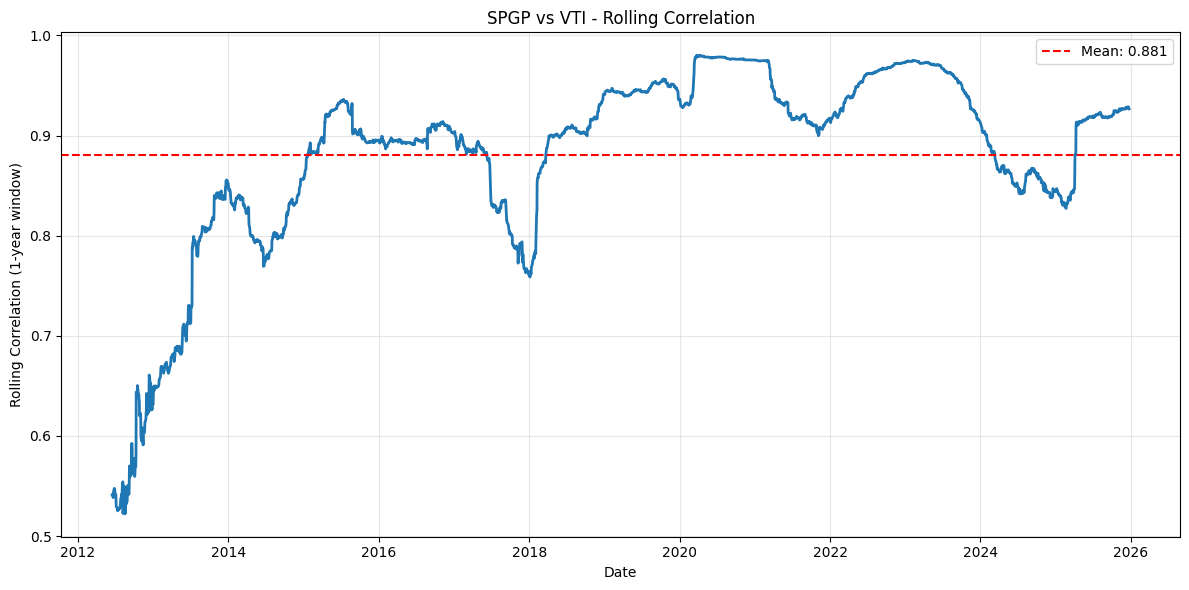

In [5]:
# Example: Rolling correlation between two stocks
result = rolling_correlation_2ticker("SPGP", "VTI", start_date="2000-01-01", end_date=None, window_days=252)
print("Stats:")
for key, value in result["stats"].items():
    print(f"  {key}: {value}")

# Plot rolling correlation over time
rolling_corr_series = result["rolling_correlation"]
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(rolling_corr_series.index, rolling_corr_series.values, linewidth=2)
plt.axhline(y=result["stats"]["Mean Correlation"], color='r', linestyle='--', label=f"Mean: {result['stats']['Mean Correlation']}")
plt.xlabel("Date")
plt.ylabel("Rolling Correlation (1-year window)")
plt.title(f"{result['stats']['Ticker 1']} vs {result['stats']['Ticker 2']} - Rolling Correlation")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
